In [ ]:
!pip install -q xgboost==1.7.6

import os
import io
import pickle
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set(style="whitegrid")
print("Libraries ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.6 MB/s eta 0:00:00
Libraries ready.


In [1]:
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print("Uploaded:", filename)
DATA_PATH = filename

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn.csv
Uploaded: Telco-Customer-Churn.csv


In [ ]:
def safe_read(path):
    try:
        if path.endswith('.csv'):
            df = pd.read_csv(path)
        elif path.endswith(('.xls','.xlsx')):
            df = pd.read_excel(path)
        else:
            raise ValueError("Unsupported file type")
        if df.empty or df.shape[1] == 0:
            raise ValueError("File empty or no columns")
        return df
    except Exception as e:
        raise RuntimeError(f"Error reading file: {e}")

df = safe_read(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
print(df.columns.tolist())

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [ ]:
df = df.copy()

if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df = df.dropna(subset=['Churn'])
df = df.fillna(method='ffill').fillna(method='bfill')

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'Churn']

le_map = {}
for c in cat_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))
    le_map[c] = le

if df['Churn'].dtype == 'object':
    df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

X = df.drop('Churn', axis=1)
y = df['Churn']

print("Final shape:", X.shape)
print("Feature columns:", X.columns.tolist()[:10])

/tmp/ipython-input-2998387730.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


Final shape: (7043, 20)
Feature columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

WORKDIR = 'output'
os.makedirs(WORKDIR, exist_ok=True)

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    out_path = os.path.join(WORKDIR, f"{name.replace(' ','_')}_model.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(model, f)
    print(f"Saved {out_path}  | Accuracy: {acc:.4f}")

with open(os.path.join(WORKDIR, "model_columns.pkl"), "wb") as f:
    pickle.dump(list(X_train.columns), f)
with open(os.path.join(WORKDIR, "label_encoders.pkl"), "wb") as f:
    pickle.dump(le_map, f)

result_df = pd.DataFrame(list(results.items()), columns=["Model","Accuracy"])
result_df["Trained_On"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
result_df.loc[len(result_df)] = [f"Best Model → {max(results, key=results.get)}", results[max(results, key=results.get)], datetime.now().strftime("%Y-%m-%d %H:%M:%S")]
csv_path = os.path.join(WORKDIR, "Model_Comparison_Report.csv")
result_df.to_csv(csv_path, index=False)
print("Saved report to:", csv_path)
display(result_df)

/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Training Decision Tree...
Saved output/Decision_Tree_model.pkl  | Accuracy: 0.7310
Training Random Forest...
Saved output/Random_Forest_model.pkl  | Accuracy: 0.7899
Training XGBoost...
Saved output/XGBoost_model.pkl  | Accuracy: 0.7828
Saved report to: output/Model_Comparison_Report.csv


,Model,Accuracy,Trained_On
0,Decision Tree,0.731015,2025-11-13 18:14:17
1,Random Forest,0.789922,2025-11-13 18:14:17
2,XGBoost,0.782825,2025-11-13 18:14:17
3,Best Model → Random Forest,0.789922,2025-11-13 18:14:17


Best model: Random Forest
Accuracy (test): 0.7899219304471257

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



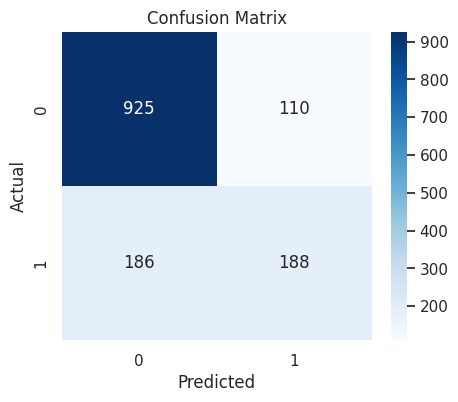

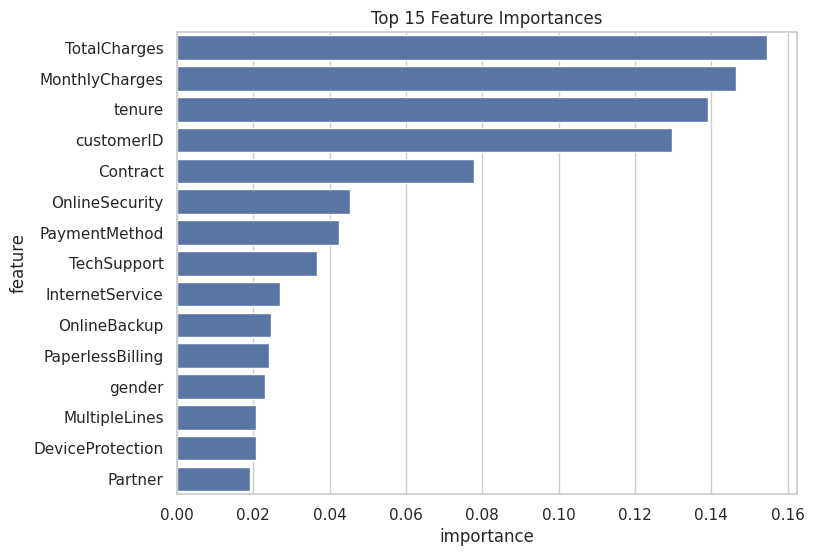

In [ ]:
best_name = max(results, key=results.get)
best_model_path = os.path.join(WORKDIR, f"{best_name.replace(' ','_')}_model.pkl")
with open(best_model_path, "rb") as f:
    best_model = pickle.load(f)

print("Best model:", best_name)
y_pred_best = best_model.predict(X_test)
print("Accuracy (test):", accuracy_score(y_test, y_pred_best))
print("\nClassification report:\n", classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_df = pd.DataFrame({"feature": X.columns, "importance": importances}).sort_values("importance", ascending=False).head(15)
    plt.figure(figsize=(8,6))
    sns.barplot(x="importance", y="feature", data=feat_df)
    plt.title("Top 15 Feature Importances")
    plt.show()
else:
    print("No feature_importances_ attribute for this model.")

In [ ]:
def load_artifacts(workdir=WORKDIR):
    with open(os.path.join(workdir, "model_columns.pkl"), "rb") as f:
        model_cols = pickle.load(f)
    with open(os.path.join(workdir, "label_encoders.pkl"), "rb") as f:
        le_map_local = pickle.load(f)
    return model_cols, le_map_local

def predict_single(customer_dict, model_file, workdir=WORKDIR):
    """
    customer_dict: map of column -> value for only a subset of columns you want to fill
    model_file: path to pkl file (e.g., WORKDIR + '/Random_Forest_model.pkl')
    """
    model_cols, le_map_local = load_artifacts(workdir)
    input_df = pd.DataFrame(columns=model_cols)

    for c in model_cols:
        input_df.at[0,c] = 0

    for k,v in customer_dict.items():
        if k in le_map_local and isinstance(v, str):

            le = le_map_local[k]
            try:
                input_df.at[0,k] = int(le.transform([v])[0])
            except Exception:

                input_df.at[0,k] = 0
        else:

            if k in input_df.columns:
                input_df.at[0,k] = v

    input_df = input_df[model_cols].astype(float)

    with open(model_file, "rb") as f:
        model = pickle.load(f)
    pred = model.predict(input_df)[0]
    pred_proba = None
    if hasattr(model, "predict_proba"):
        pred_proba = model.predict_proba(input_df)[0].tolist()
    return int(pred), pred_proba

sample_customer = {
    "gender": "Male",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 12,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "DSL",
    "Contract": "Month-to-month",
    "MonthlyCharges": 70.0,
    "TotalCharges": 2000.0
}

model_file_example = os.path.join(WORKDIR, "Random_Forest_model.pkl")
pred_label, pred_proba = predict_single(sample_customer, model_file_example)
print("Prediction (1=Churn,0=Stay):", pred_label)
print("Probabilities (if available):", pred_proba)

Prediction (1=Churn,0=Stay): 0
Probabilities (if available): [0.76, 0.24]


In [ ]:
!ls -la "{WORKDIR}"

from google.colab import files
files.download(os.path.join(WORKDIR, "Model_Comparison_Report.csv"))

total 16472
drwxr-xr-x 2 root root     4096 Nov 13 18:14 .
drwxr-xr-x 1 root root     4096 Nov 13 18:14 ..
-rw-r--r-- 1 root root   159215 Nov 13 18:14 Decision_Tree_model.pkl
-rw-r--r-- 1 root root    93302 Nov 13 18:14 label_encoders.pkl
-rw-r--r-- 1 root root      310 Nov 13 18:14 model_columns.pkl
-rw-r--r-- 1 root root      247 Nov 13 18:14 Model_Comparison_Report.csv
-rw-r--r-- 1 root root 16329165 Nov 13 18:14 Random_Forest_model.pkl
-rw-r--r-- 1 root root   263681 Nov 13 18:14 XGBoost_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-691363512.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='coolwarm')


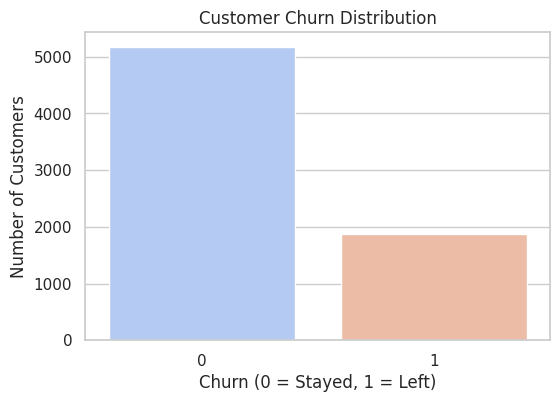

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='coolwarm')
plt.title("Customer Churn Distribution")
plt.xlabel("Churn (0 = Stayed, 1 = Left)")
plt.ylabel("Number of Customers")
plt.show()

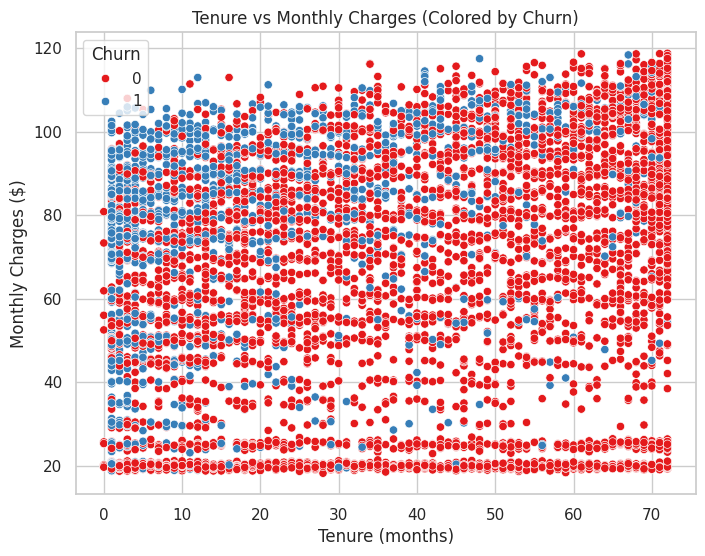

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=df, palette='Set1')
plt.title("Tenure vs Monthly Charges (Colored by Churn)")
plt.xlabel("Tenure (months)")
plt.ylabel("Monthly Charges ($)")
plt.show()

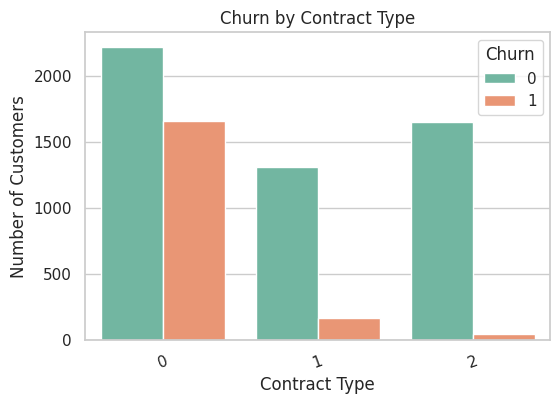

In [ ]:
if 'Contract' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Contract', hue='Churn', data=df, palette='Set2')
    plt.title("Churn by Contract Type")
    plt.xlabel("Contract Type")
    plt.ylabel("Number of Customers")
    plt.xticks(rotation=20)
    plt.show()

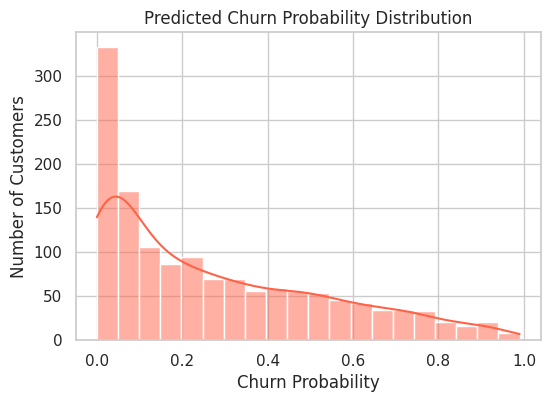

In [ ]:
if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(6,4))
    sns.histplot(y_prob, bins=20, kde=True, color='tomato')
    plt.title("Predicted Churn Probability Distribution")
    plt.xlabel("Churn Probability")
    plt.ylabel("Number of Customers")
    plt.show()